# Set Parameter
- Attention = [None, Luong]
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Drop out = 0.2
- Hidden unit = 50
- Epochs = 100
- N = 100
- Data Length = 100K
- Deduplication

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
character_accuracy = []
sentance_accuracy = []

In [4]:
train_path = "data/bracket_dedup/K100/data_train.txt"
dev_path = "data/bracket_dedup/K100/data_test.txt"

src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()
    
optimizer = "Adam"
hidden_size = 50
bidirectional = True

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Prepare dataset

In [ ]:
print("None Att")

seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="bracket_dedup_K100_parameter/None_att")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, train,
                                                                             num_epochs=100, dev_data=dev,
                                                                             optimizer=optimizer,
                                                                             teacher_forcing_ratio=0.5)

character_accuracy.append(character_accuracy_list)
sentance_accuracy.append(sentance_accuracy_list)

torch.save(seq2seq.state_dict(), 'log/pth/bracket_dedup_K100_parameter_no_att_model_save.pth')

2019-03-06 17:25:24,227 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


None Att


2019-03-06 17:29:26,948 INFO   Finished epoch 1: Train loss: 14.0922, Dev loss: 10.3817, Accuracy(Character): 0.2573, Accuracy(Word): 0.0002
2019-03-06 17:33:29,459 INFO   Finished epoch 2: Train loss: 6.2319, Dev loss: 5.8595, Accuracy(Character): 0.3723, Accuracy(Word): 0.0072
2019-03-06 17:37:34,685 INFO   Finished epoch 3: Train loss: 3.5071, Dev loss: 4.0439, Accuracy(Character): 0.4646, Accuracy(Word): 0.0357
2019-03-06 17:41:40,518 INFO   Finished epoch 4: Train loss: 2.9454, Dev loss: 3.6685, Accuracy(Character): 0.4991, Accuracy(Word): 0.0331
2019-03-06 17:45:50,248 INFO   Finished epoch 5: Train loss: 2.5803, Dev loss: 3.6566, Accuracy(Character): 0.5132, Accuracy(Word): 0.0699


In [ ]:
print("Luong Att")

seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="bracket_dedup_K100_parameter/Luong_att")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, train,
                                                                             num_epochs=100, dev_data=dev,
                                                                             optimizer=optimizer,
                                                                             teacher_forcing_ratio=0.5)

character_accuracy.append(character_accuracy_list)
sentance_accuracy.append(sentance_accuracy_list)

torch.save(seq2seq.state_dict(), 'log/pth/bracket_dedup_K100_parameter_Luong_att_model_save.pth')

2019-03-07 00:32:18,260 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Luong Att


/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-03-07 00:37:11,862 INFO   Finished epoch 1: Train loss: 18.2153, Dev loss: 20.7435, Accuracy(Character): 0.2074, Accuracy(Word): 0.0026


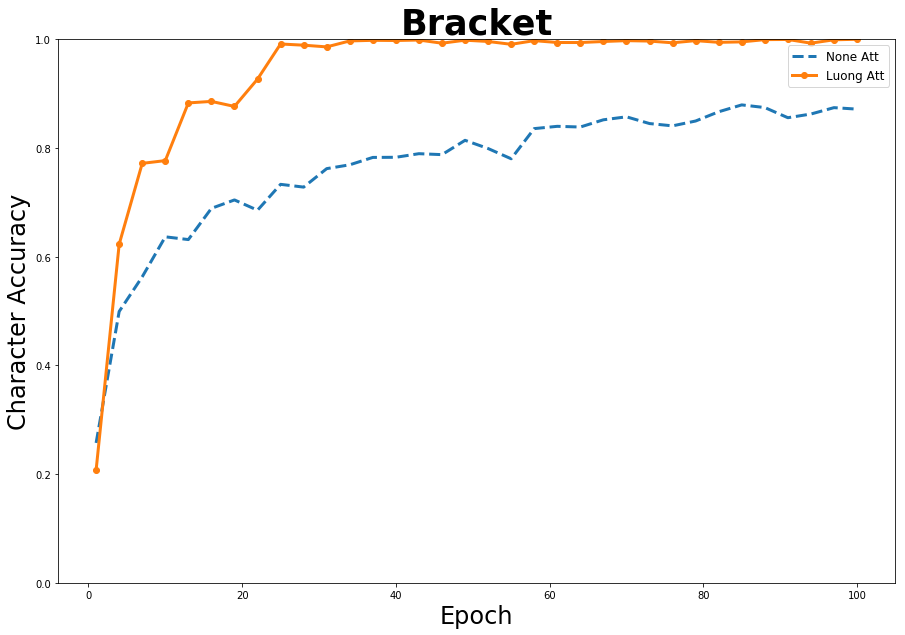

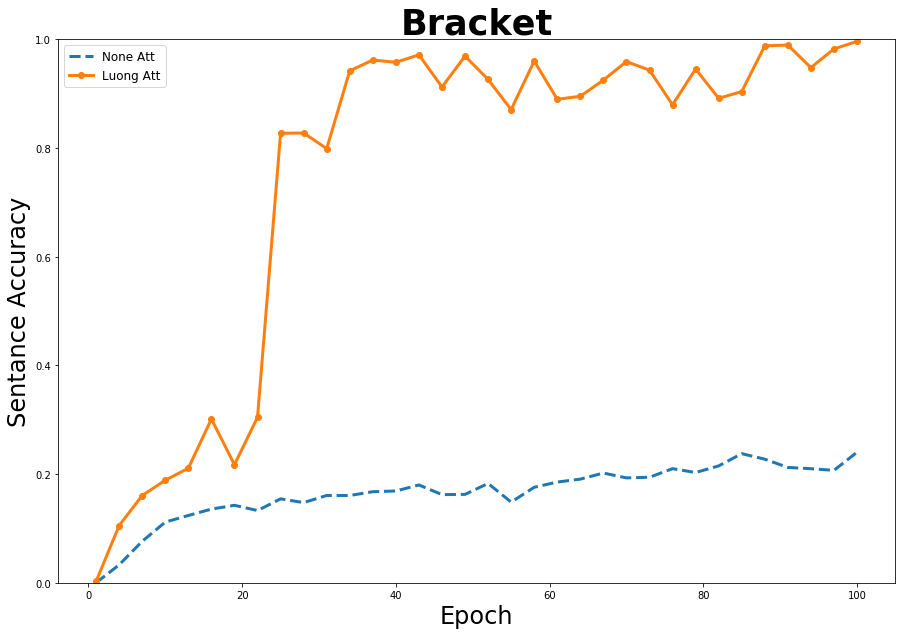

In [16]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,10))
plt.plot(epochs[::3], character_accuracy[0][::3], '--', LineWidth=3, label="None Att")
plt.plot(epochs[::3], character_accuracy[1][::3], '-o', LineWidth=3, label="Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Character Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.title('Bracket', fontsize=35, fontweight=560)
plt.savefig('log/plot/bracket_dedup_K100_parameter/epoch_to_character_accuracy.png')

plt.figure(figsize=(15,10))
plt.plot(epochs[::3], sentance_accuracy[0][::3], '--', LineWidth=3, label="None Att")
plt.plot(epochs[::3], sentance_accuracy[1][::3], '-o', LineWidth=3, label="Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentance Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.title('Bracket', fontsize=35, fontweight=560)
plt.savefig('log/plot/bracket_dedup_K100_parameter/epoch_to_sentance_accuracy.png')

In [14]:
print(character_accuracy[0])
print(character_accuracy[1])

[0.257324092549339, 0.3723112381203692, 0.46463749299276663, 0.49913013105558013, 0.5131857089726687, 0.55235865306873, 0.5629251944576967, 0.5910191409410774, 0.581464764332282, 0.6364524644268378, 0.6273327832714912, 0.6404992113974344, 0.6313964209012027, 0.655045893195582, 0.6740405547912267, 0.6888288048838863, 0.6621262662815597, 0.7011344467783298, 0.7043149897588428, 0.7076641206388239, 0.7175171113531044, 0.6854060562254986, 0.7081584114366971, 0.7190353585233612, 0.7329950102443441, 0.7460977000340044, 0.7488107223178828, 0.7279051854004791, 0.752842490779453, 0.7198881774628254, 0.7618911036898441, 0.7677543932445012, 0.75753841270509, 0.7689574543418395, 0.760875114609496, 0.7450609959943643, 0.7825219283778689, 0.7801706211523955, 0.7789659665966501, 0.7827647714391065, 0.7879906776309352, 0.7816993851481391, 0.7893935584125202, 0.7974825906701736, 0.7880576028840323, 0.7876372485562471, 0.7935151979282491, 0.8117453181801813, 0.8139860393922039, 0.7829961415998131, 0.8217

In [15]:
print(sentance_accuracy[0])
print(sentance_accuracy[1])

[0.00016899385284860262, 0.007182238746065612, 0.03565770295105516, 0.03308054669511396, 0.06992120661610934, 0.08861615158748601, 0.07636409725596231, 0.10492405838737616, 0.11031073744692536, 0.11170493673292634, 0.12148545596653922, 0.09554489955427871, 0.12385136990641965, 0.10576902765161918, 0.13975791630579437, 0.13557531844779147, 0.13743425082912608, 0.14362365068970617, 0.14258856334100847, 0.1486512178119521, 0.14653879465134456, 0.1328925410338199, 0.14934831745495258, 0.14100424597055283, 0.15441813304041066, 0.15765014047614018, 0.1571009104543822, 0.14755275776843618, 0.15655168043262427, 0.1590654639937472, 0.1606286571325968, 0.1667969327615708, 0.15346754261813728, 0.16060753290099072, 0.15862185513001964, 0.1643887703584782, 0.16755740509938952, 0.16939521324911808, 0.16117788715435477, 0.1689304801537844, 0.16445214305329645, 0.16398740995796277, 0.17995732905215572, 0.17642958237394116, 0.15781913432898878, 0.16223409873465852, 0.1604596632797482, 0.174253786518515

In [ ]:
print(f1_score[0])
print(f1_score[1])